In [1]:
import sqlite3
import csv

from google.colab import drive
drive.mount('/content/drive')

dbpath = '/' 
# データベースのパスを指定するように適宜変更する

conn = sqlite3.connect(dbpath)

# カーソルの取得
cur = conn.cursor()

# テーブル名の確認
cur.execute('select name from sqlite_master where type = "table"')
for row in cur.fetchall():
  print(row)

# Clientテーブルから全データを取得
cur.execute('select * from Client')
with open('Client.csv','w',newline = '') as csv_file:
  csv_writer = csv.writer(csv_file)
  csv_writer.writerow([i[0] for i in cur.description])
  csv_writer.writerows(cur)

# Recordテーブルから全データを取得
cur.execute('select * from Record')
with open('Record.csv','w',newline = '') as csv_file:
  csv_writer = csv.writer(csv_file)
  csv_writer.writerow([i[0] for i in cur.description])
  csv_writer.writerows(cur)

# 処理の確定
conn.commit()

# カーソルを閉じる
cur.close()

# 接続を閉じる
conn.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
('Record',)
('Client',)


In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

Client = pd.read_csv("/content/Client.csv")
Record = pd.read_csv("/content/Record.csv")

from google.colab import drive
drive.mount('/content/drive')

print('データのデータ数は{}、変数は{}種類です。'.format(Client.shape[0], Client.shape[1]))
print('データのデータ数は{}、変数は{}種類です。'.format(Record.shape[0], Record.shape[1]))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
データのデータ数は100000、変数は50種類です。
データのデータ数は100000、変数は50種類です。


In [ ]:
print(Client.info())

In [ ]:
print(Record.info())

In [ ]:
Client.head()

In [ ]:
Record.head()

In [ ]:
Client.isnull().sum()

In [ ]:
Record.isnull().sum()

In [ ]:
# Recordの欠損値を平均値で補完
Record["rev_Mean"].fillna(Record["rev_Mean"].mean(), inplace=True)
Record["mou_Mean"].fillna(Record["mou_Mean"].mean(), inplace=True)
Record["totmrc_Mean"].fillna(Record["totmrc_Mean"].mean(), inplace=True)
Record["da_Mean"].fillna(Record["da_Mean"].mean(), inplace=True)
Record["ovrmou_Mean"].fillna(Record["ovrmou_Mean"].mean(), inplace=True)
Record["ovrrev_Mean"].fillna(Record["ovrrev_Mean"].mean(), inplace=True)
Record["vceovr_Mean"].fillna(Record["vceovr_Mean"].mean(), inplace=True)
Record["datovr_Mean"].fillna(Record["datovr_Mean"].mean(), inplace=True)
Record["roam_Mean"].fillna(Record["roam_Mean"].mean(), inplace=True)
Record["change_mou"].fillna(Record["change_mou"].mean(), inplace=True)
Record["change_rev"].fillna(Record["change_rev"].mean(), inplace=True)

In [ ]:
Record.isnull().sum()

In [ ]:
Record['rev_Mean'].sum()

5871998.484590209

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


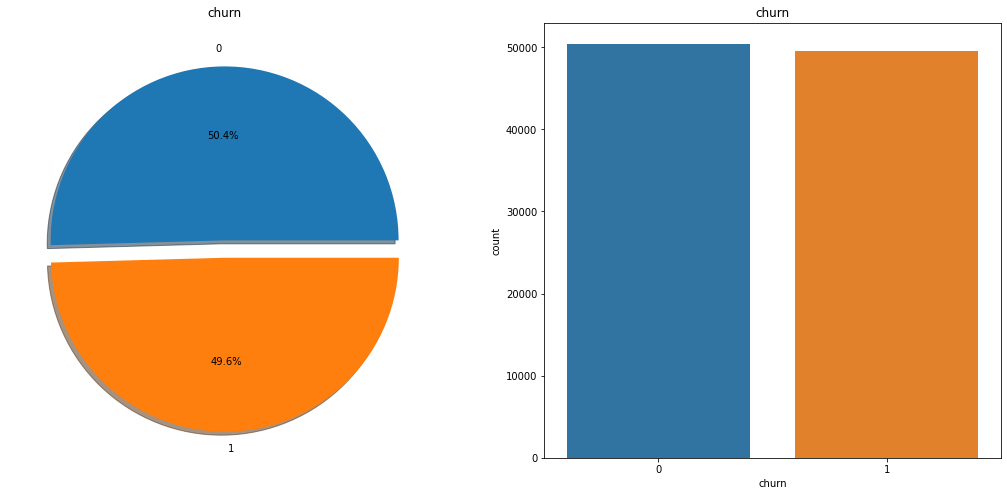

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
Record['churn'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('churn')
ax[0].set_ylabel('')
sns.countplot('churn',data=Record,ax=ax[1])
ax[1].set_title('churn')
plt.show()

Text(0, 0.5, '')

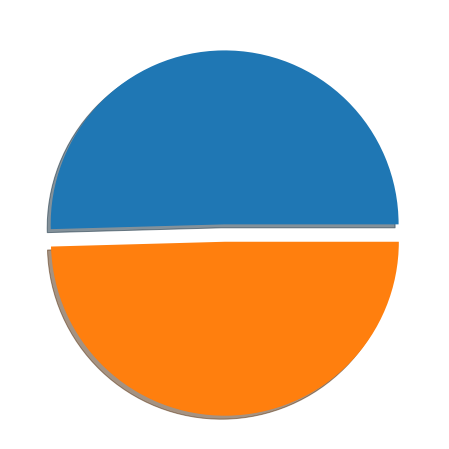

In [ ]:
f,ax=plt.subplots(1,1,figsize=(18,8))
Labels=['','']
Record['churn'].value_counts().plot.pie(explode=[0,0.1],labels=Labels,shadow=True)
plt.title('')
plt.ylabel('')

In [ ]:
pip install japanize-matplotlib

In [ ]:
Record['churn'].value_counts()

0    50438
1    49562
Name: churn, dtype: int64

Text(0.5, 1.0, '解約したかどうか')

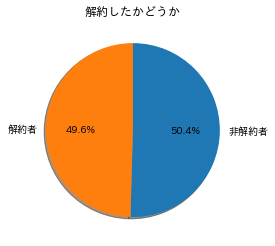

In [ ]:
import japanize_matplotlib

x = [50438, 49562]
Labels = ['非解約者', '解約者']
plt.pie(x, labels=Labels, startangle=90, counterclock=False, autopct='%1.1f%%', shadow=True)
plt.title('解約したかどうか')

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [ ]:
X = Record.drop('churn',axis=1) 
y = Record['churn'] # 目的変数
# トレーニングデータ,テストデータの分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.2, random_state=0)

In [ ]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train) 

# パラメータ
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # 目的 : 分類
        'metric': {'auc'},
         'num_leaves': 20,             
        'max_depth':5,
        'min_data_in_leaf': 3,        
        'num_iteration': 100,            
        'learning_rate':0.03,
        'num_boost_round':100,
         'early_stopping_rounds':20, 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# テストデータの予測
y_pred = model.predict(X_valid)

In [ ]:
lgb.plot_importance(model, height=0.5, figsize=(30,40))

In [ ]:
Record.groupby(["churn"])["change_mou"].mean()

In [ ]:
Record.groupby(["churn"])["change_mou"].median()

In [ ]:
sns.barplot(x='churn', y='change_mou', data=Record, estimator=np.median)

In [ ]:
Record.groupby('churn')['change_mou'].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
from scipy import stats
s, pvalue = stats.mannwhitneyu(Record[Record["churn"]==1]["change_mou"]
                , Record[Record["churn"]==0]["change_mou"]
                ,alternative='two-sided')
pvalue < 0.05

True

In [ ]:
Record.groupby(["churn"])["months"].mean()

In [ ]:
Record.groupby(["churn"])["months"].median()

In [ ]:
sns.barplot(x='churn', y='months', data=Record, estimator=np.median)

In [ ]:
Record.groupby(["churn"])["months"].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
s, pvalue = stats.mannwhitneyu(Record[Record["churn"]==1]["months"]
                , Record[Record["churn"]==0]["months"]
                ,alternative='two-sided')
pvalue < 0.05

In [ ]:
Record.groupby(["churn"])["mou_Mean"].mean()

In [ ]:
Record.groupby(["churn"])["mou_Mean"].median()

In [ ]:
sns.barplot(x='churn', y='mou_Mean', data=Record, estimator=np.median)

In [ ]:
Record.groupby(["churn"])["mou_Mean"].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
s, pvalue = stats.mannwhitneyu(Record[Record["churn"]==1]["mou_Mean"]
                , Record[Record["churn"]==0]["mou_Mean"]
                ,alternative='two-sided')
pvalue < 0.05

In [ ]:
Record.groupby(["churn"])["totmrc_Mean"].mean()

In [ ]:
Record.groupby(["churn"])["totmrc_Mean"].median()

In [ ]:
sns.barplot(x='churn', y='totmrc_Mean', data=Record, estimator=np.median)

In [ ]:
Record.groupby(["churn"])["totmrc_Mean"].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
s, pvalue = stats.mannwhitneyu(Record[Record["churn"]==1]["totmrc_Mean"]
                , Record[Record["churn"]==0]["totmrc_Mean"]
                ,alternative='two-sided')
pvalue < 0.05

In [ ]:
Record.groupby(["churn"])["change_rev"].mean()

In [ ]:
Record.groupby(["churn"])["change_rev"].median()

In [ ]:
sns.barplot(x='churn', y='change_rev', data=Record, estimator=np.median)

In [ ]:
Record.groupby(["churn"])["change_rev"].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
s, pvalue = stats.mannwhitneyu(Record[Record["churn"]==1]["change_rev"]
                , Record[Record["churn"]==0]["change_rev"]
                ,alternative='two-sided')
pvalue < 0.05

In [ ]:
Record.groupby(["churn"])["vceovr_Mean"].mean()

In [ ]:
Record.groupby(["churn"])["vceovr_Mean"].median()

In [ ]:
sns.barplot(x='churn', y='vceovr_Mean', data=Record, estimator=np.median)

In [ ]:
Record.groupby(["churn"])["vceovr_Mean"].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
s, pvalue = stats.mannwhitneyu(Record[Record["churn"]==1]["vceovr_Mean"]
                , Record[Record["churn"]==0]["vceovr_Mean"]
                ,alternative='two-sided')
pvalue < 0.05

In [ ]:
Record.groupby(["churn"])["rev_Mean"].mean()

In [ ]:
Record.groupby(["churn"])["rev_Mean"].median()

In [ ]:
sns.barplot(x='churn', y='rev_Mean', data=Record, estimator=np.median)

In [ ]:
Record.groupby(["churn"])["rev_Mean"].plot.hist(bins=20, alpha=0.5, legend=True)

In [ ]:
s, pvalue = stats.mannwhitneyu(Record[Record["churn"]==1]["rev_Mean"]
                , Record[Record["churn"]==0]["rev_Mean"]
                ,alternative='two-sided')
pvalue < 0.05

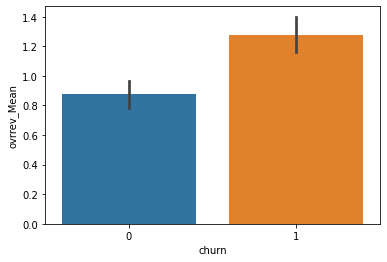

In [ ]:
sns.barplot(x='churn', y='ovrrev_Mean', data=Record, estimator=np.median)

In [ ]:
s, pvalue = stats.mannwhitneyu(Record[Record["churn"]==1]["ovrrev_Mean"]
                , Record[Record["churn"]==0]["ovrrev_Mean"]
                ,alternative='two-sided')
pvalue < 0.05

True

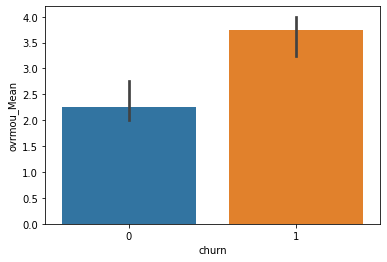

In [ ]:
sns.barplot(x='churn', y='ovrmou_Mean', data=Record, estimator=np.median)


In [ ]:
s, pvalue = stats.mannwhitneyu(Record[Record["churn"]==1]["ovrrev_Mean"]
                , Record[Record["churn"]==0]["ovrrev_Mean"]
                ,alternative='two-sided')
pvalue < 0.05

True

In [ ]:
# ライブラリの読み込み
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# 目的変数と説明変数に分割
X = Record[["change_mou", "mou_Mean", "totmrc_Mean", "rev_Mean", "change_rev", "ovrmou_Mean", "ovrrev_Mean", "months"]].values
y = Record["churn"].values

# 標準化
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

# 訓練データと評価データに分割
X_train, X_valid, y_train, y_valid = train_test_split(X_std, y, test_size=0.3, stratify=y, random_state=0)

In [ ]:
# LGBMClassifier
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=0)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

Train Score: 0.7021348530675647
Valid Score: 0.6567323497060147


In [ ]:
# テストデータに対する予測値の作成
pred = lgb.predict(X_valid)
pred

array([0, 1, 0, ..., 1, 0, 1])

In [ ]:
cust = pd.DataFrame()
cust['churn'] = pred
cust['churn']
cust[cust['churn']==1]

,churn
1,1
3,1
5,1
8,1
13,1
...,...
29990,1
29991,1
29993,1
29997,1


Text(0, 0.5, '')

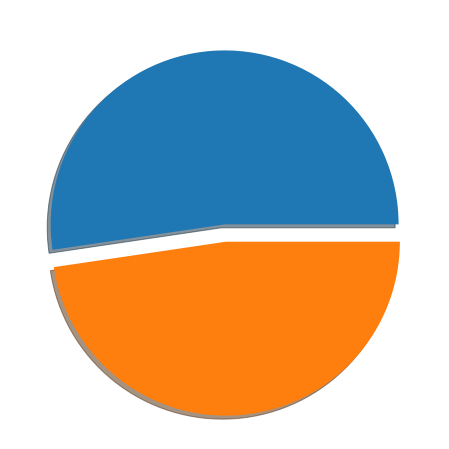

In [ ]:
f,ax=plt.subplots(1,1,figsize=(18,8))
cust['churn'].value_counts().plot.pie(explode=[0,0.1],labels=Labels,shadow=True)
plt.title('')
plt.ylabel('')

In [ ]:
Record['now_charge'] = Record['rev_Mean'] - Record['ovrrev_Mean']
Record['now_ovr_charge'] = Record['ovrrev_Mean']/Record['ovrmou_Mean']
Record['nor_time'] = Record['mou_Mean'] - Record['ovrmou_Mean']
Record['res_totmrc'] = Record['totmrc_Mean'] - Record['rev_Mean'] - Record['ovrrev_Mean']
Record['now_charge'].median()

38.24

In [ ]:
Record['now_ovr_charge'].median()

0.35000000000000003

In [ ]:
Record['nor_time'].median()

331.0

In [ ]:
Record['new_charge'] = Record['now_charge'] - 3
Record['new_ovr_charge'] = Record['now_ovr_charge'] - 0.15

In [ ]:
Record['ovrrev_Mean'] = Record['new_ovr_charge']*Record['ovrmou_Mean']
Record['rev_Mean'] = Record['new_charge'] + Record['ovrrev_Mean']
Record['totmrc_Mean'] = Record['res_totmrc'] + Record['new_charge'] + Record['ovrrev_Mean']

In [ ]:
X = Record[["change_mou", "mou_Mean", "totmrc_Mean", "rev_Mean", "change_rev", "ovrmou_Mean", "ovrrev_Mean", "months"]].values
y = Record["churn"].values

# 訓練データと評価データに分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [ ]:
# テストデータに対する予測値の作成
pred = lgb.predict(X_valid)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
cust = pd.DataFrame()
cust['churn'] = pred
cust['churn']
cust[cust['churn']==1]

,churn
149,1
207,1
245,1
537,1
599,1
...,...
29473,1
29611,1
29630,1
29871,1


Text(0, 0.5, '')

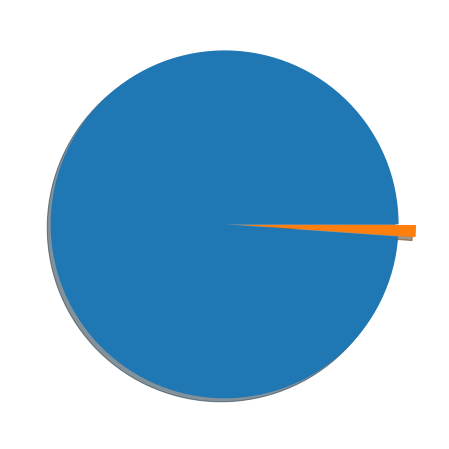

In [ ]:
f,ax=plt.subplots(1,1,figsize=(18,8))
cust['churn'].value_counts().plot.pie(explode=[0,0.1],labels=Labels,shadow=True)
plt.title('')
plt.ylabel('')

In [ ]:
Record[['now_charge', 'now_ovr_charge', 'nor_time']].describe()

,now_charge,now_ovr_charge,nor_time
count,100000.000000,57460.00,100000.000000
mean,45.160425,inf,472.487690
std,29.612950,NaN,475.011502
min,-101.572500,0.00,0.000000
25%,30.420000,0.30,142.750000
50%,38.240000,0.35,331.000000
75%,53.982500,0.39,644.250000
max,3814.455000,inf,12124.500000


In [ ]:
df = pd.DataFrame()
df['now_ovr_charge'] = Record['now_ovr_charge']
df['ovrmou_Mean'] = Record['ovrmou_Mean']
df['ovrrev_Mean'] = Record['ovrrev_Mean']
df.dropna().describe()

,now_ovr_charge,ovrmou_Mean,ovrrev_Mean
count,57397.000000,57397.000000,57397.000000
mean,0.352083,71.558177,12.888790
std,0.192116,119.385003,20.890383
min,0.000000,0.250000,-216.037500
25%,0.300000,9.250000,1.700000
50%,0.350000,33.250000,6.150000
75%,0.390000,85.750000,15.825000
max,39.890000,4320.750000,689.000000


In [ ]:
Record['rev_Mean'].sum()

3272326.7611977835

In [ ]:
Record[['charge1', 'ovr_charge', 'new_charge', 'new_ovr_charge']].head()

,charge1,ovr_charge,new_charge,new_ovr_charge
0,23.9975,NaN,23.9975,NaN
1,48.3925,0.4,48.3925,0.25
2,16.9900,NaN,16.9900,NaN
3,38.0000,NaN,38.0000,NaN
4,55.2300,NaN,55.2300,NaN


In [ ]:
Record[['new_ovr_rev', 'ovrrev_Mean']].head()

,new_ovr_rev,ovrrev_Mean
0,NaN,0.0
1,5.6875,9.1
2,NaN,0.0
3,NaN,0.0
4,NaN,0.0


In [ ]:
Record['new_rev_Mean'] = Record['new_charge'] + Record['new_ovr_rev']
Record['new_rev_Mean'].sum()

3444517.7611977835

In [ ]:
loss_sum = Record[Record["churn"]==1]
loss_sum['rev_Mean'].sum()
get_sum = Record[Record["churn"]==0]
get_sum['rev_Mean'].sum()
Record['rev_Mean'].sum()
get_sum['ovrrev_Mean'].sum()
loss_sum['ovrrev_Mean'].sum()
Record['ovrrev_Mean'].sum()

2885181.929620611